In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Checking if we are using google colab or local machine and configuring 
# imports accordingly
import os
google_colab = input('Running on Colab?\n')
if google_colab == 'yes' : 
    BASE_DIR = 'University/UC3M/TFM/cnp_repo/neural-processes'

    # Load the Drive helper and mount
    from google.colab import drive

    # This will prompt for authorization.
    drive.mount('/content/drive')

      # Change to assignment directory ('Lab_Exercises_DASS/Lab_Exercise4' by default)
    import os
    os.chdir(f'/content/drive/My Drive/{BASE_DIR}')
    
else:
    import sys, os 
    BASE_DIR = '/'.join(os.getcwd().split('/')[:-1])
    sys.path.append(BASE_DIR)
    print(f'Top level directory is set to {BASE_DIR}')
    os.chdir(BASE_DIR)

    
# custom imports
from cnp.trainer import RegressionTrainer
from cnp.datageneration import DataGenerator
from cnp.helpers import Helper
from cnp.cnp import RegressionCNP
from cnp.run_experiment import run_experiment

import torch
import numpy as np
from copy import copy

# import utils
import json
from datetime import date

Running on Colab?
yes
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
if google_colab=='yes':
    config_dir = 'base_configs'
else:
    config_dir = os.path.join(BASE_DIR,'base_configs')

# checkin the parameters
# loading the base config file for this experiment
with open(os.path.join(config_dir,'gp_paper_configs.json')) as f:
    file = f.read()
    base_config = json.loads(file)
base_config

{'cnp_params': {'aggregation_kwargs': {'aggregator': None,
   'simple_aggregator_type': 'mean'},
  'dimout': 2,
  'dimr': 128,
  'dimx': 1,
  'dimy': 1,
  'dropout': 0.2,
  'max_contx': 10,
  'max_funcs': 10,
  'min_contx': 3,
  'min_funcs': 2,
  'num_layers_decoder': 3,
  'num_layers_encoder': 4,
  'num_neurons_decoder': 128,
  'num_neurons_encoder': 128},
 'data_kwargs': {'datagenerator': 'cnp.datageneration.GaussianProcess',
  'gamma': 1,
  'init_kwargs': {'range_x': [-2, 2], 'steps': 400, 'xdim': 1},
  'length_scale': 0.4,
  'noise': 0.0004,
  'num_instances_test': 100,
  'num_instances_train': 64,
  'num_instances_vali': 10},
 'experiment_params': {'lr': 0.0001,
  'n_epochs': 200000,
  'seed': 1,
  'train_on_gpu': False},
 'train_kwargs': {'batch_size_test': 10,
  'batch_size_train': 64,
  'batch_size_vali': 10,
  'plot_mode': '1d_regression',
  'plot_progress': True,
  'print_after': 1000}}

In [4]:
# checking whether CUDA is available 
train_on_gpu = torch.cuda.is_available()
if(train_on_gpu):
    print('Training on GPU!')
    base_config['experiment_params']['train_on_gpu'] = True
else: 
    print('No GPU available, training on CPU')
    base_config['experiment_params']['train_on_gpu'] = False

Training on GPU!


In [5]:
base_config['cnp_params']['dimx'] = 1
base_config['data_kwargs']['init_kwargs']['xdim'] = 1
base_config['train_kwargs']['plot_mode'] = '1d_regression'

In [6]:
base_config['train_kwargs']['print_after'] = 1000

## Simple Mean Experiment 

In [7]:
mean_exp_config = copy(base_config)

In [8]:
run_experiment(config_file=mean_exp_config,
               experiment_name='1d_gp_mean_5ctxt',
              google_colab=google_colab)

Output hidden; open in https://colab.research.google.com to view.

Decoder(
  (_process_input): Sequential(
    (0): Linear(in_features=129, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=128, out_features=2, bias=True)
  )
)
Encoder(
  (_process_input): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=128, out_features=128, bias=True)
  )
)
Aggregation using mean operation
seed is set


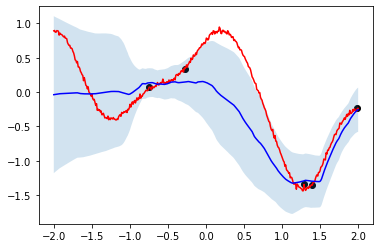

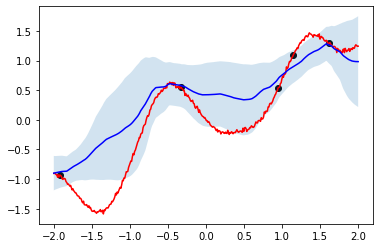

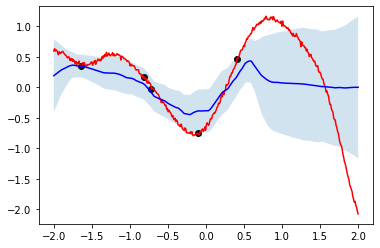

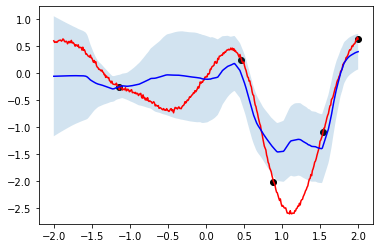

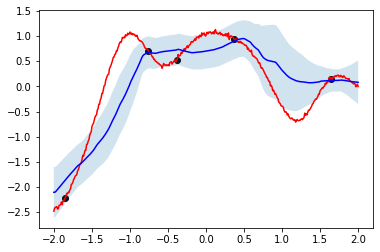

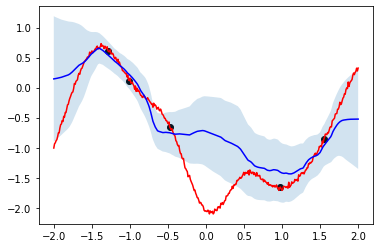

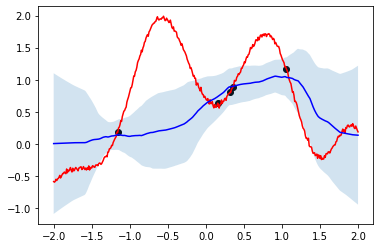

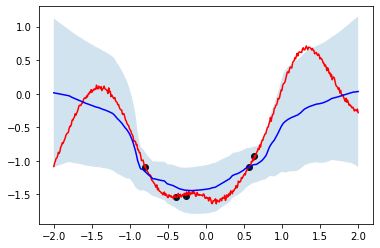

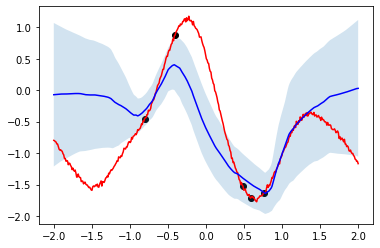

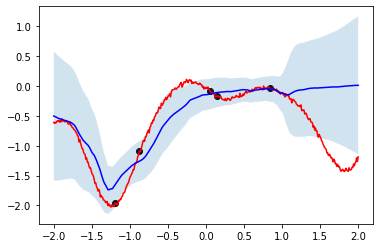

In [10]:
## Predicting with twice the number of context points
experiment_name = '1d_gp_mean_5ctxt_2020_07_01_09_11'
result_path = 'experiments/results'
with open(os.path.join(result_path, experiment_name,'config_file.json')) as file:
    experiment_config = json.load(file)

experiment_config['cnp_params']['max_contx']=10
CondNeuralProcess = RegressionCNP(**experiment_config['cnp_params'])

trainer = RegressionTrainer(
    data_kwargs=experiment_config['data_kwargs'],
    cnp=CondNeuralProcess,
     **experiment_config['experiment_params'])

if train_on_gpu:
    encoder_state_dict = torch.load(os.path.join(result_path, experiment_name, 'encoder'))
    decoder_state_dict = torch.load(os.path.join(result_path, experiment_name, 'decoder'))
else:
    encoder_state_dict = torch.load(os.path.join(result_path, experiment_name, 'encoder'),map_location=torch.device('cpu'))
    decoder_state_dict = torch.load(os.path.join(result_path, experiment_name, 'decoder'),map_location=torch.device('cpu'))

total_mse, task_mses = trainer.run_test(
    encoder_state_dict,
    decoder_state_dict,
    aggregator_state_dict=None,
    batch_size_test=experiment_config['train_kwargs']['batch_size_test'],
    plot_mode=experiment_config['train_kwargs']['plot_mode'])

Decoder(
  (_process_input): Sequential(
    (0): Linear(in_features=129, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=128, out_features=2, bias=True)
  )
)
Encoder(
  (_process_input): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=128, out_features=128, bias=True)
  )
)
Aggregation using mean operation
seed is set


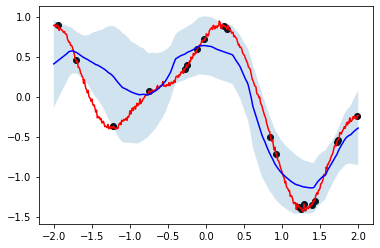

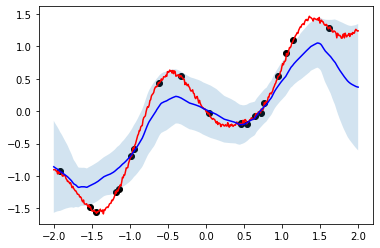

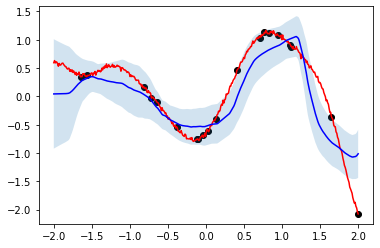

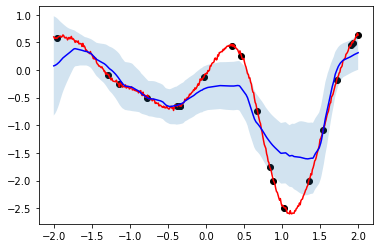

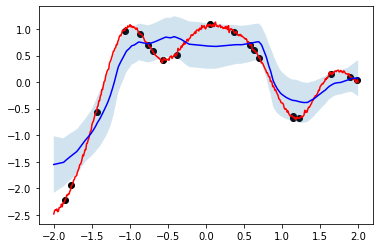

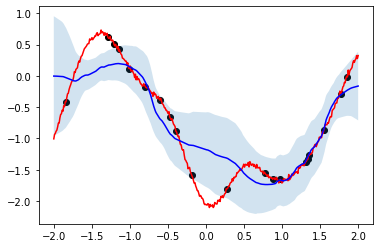

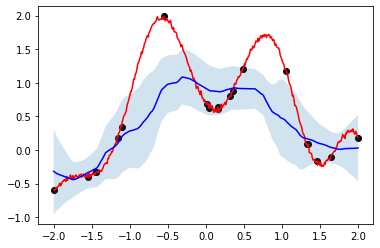

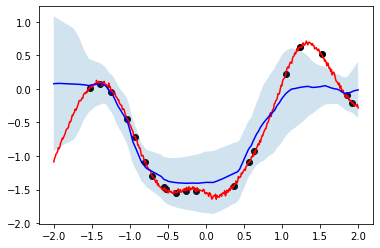

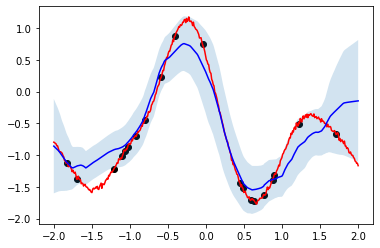

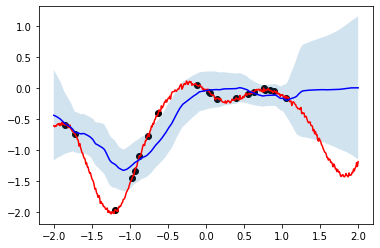

In [12]:
## Predicting with twice the number of context points
experiment_name = '1d_gp_mean_5ctxt_2020_07_01_09_11'
result_path = 'experiments/results'
with open(os.path.join(result_path, experiment_name,'config_file.json')) as file:
    experiment_config = json.load(file)

experiment_config['cnp_params']['max_contx']=40
CondNeuralProcess = RegressionCNP(**experiment_config['cnp_params'])

trainer = RegressionTrainer(
    data_kwargs=experiment_config['data_kwargs'],
    cnp=CondNeuralProcess,
     **experiment_config['experiment_params'])

if train_on_gpu:
    encoder_state_dict = torch.load(os.path.join(result_path, experiment_name, 'encoder'))
    decoder_state_dict = torch.load(os.path.join(result_path, experiment_name, 'decoder'))
else:
    encoder_state_dict = torch.load(os.path.join(result_path, experiment_name, 'encoder'),map_location=torch.device('cpu'))
    decoder_state_dict = torch.load(os.path.join(result_path, experiment_name, 'decoder'),map_location=torch.device('cpu'))

total_mse, task_mses = trainer.run_test(
    encoder_state_dict,
    decoder_state_dict,
    aggregator_state_dict=None,
    batch_size_test=experiment_config['train_kwargs']['batch_size_test'],
    plot_mode=experiment_config['train_kwargs']['plot_mode'])

## Max Experiment 

In [ ]:
max_exp_config = copy(base_config)

In [ ]:
max_exp_config['cnp_params']['aggregation_kwargs']['simple_aggregator_type']='max'


 10%|█         | 1/10 [00:00<00:01,  6.44it/s]

Training on GPU!
Decoder(
  (_process_input): Sequential(
    (0): Linear(in_features=138, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=2, bias=True)
  )
)
Encoder(
  (_process_input): Sequential(
    (0): Linear(in_features=11, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=128, bias=True)
  )
)
Aggregation using max operation
Mean training loss at epoch 0 :                         1.455
Mean Validation loss after 0 equals                     1.535



100%|██████████| 10/10 [00:01<00:00,  6.98it/s]


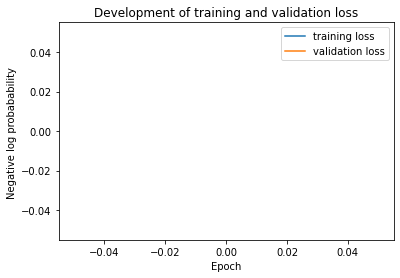

The mean squared error for this experiment is 1.0110417211055756
Creating new directory at experiments/results/10d_gp_max_2020_06_29_15_56
Saving encoder
Saving decoder
Saving train_loss
Saving vali_loss
Saving task_mses
Saving config
Saving snapshot of the sytems


In [ ]:
run_experiment(config_file=max_exp_config,
               experiment_name='1d_gp_max',
              google_colab=google_colab)

##  Sum Experiment 

In [ ]:
sum_exp_config = copy(base_config)

In [ ]:
sum_exp_config['cnp_params']['aggregation_kwargs']['simple_aggregator_type']='sum'

 10%|█         | 1/10 [00:00<00:01,  7.08it/s]

Training on GPU!
Decoder(
  (_process_input): Sequential(
    (0): Linear(in_features=138, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=2, bias=True)
  )
)
Encoder(
  (_process_input): Sequential(
    (0): Linear(in_features=11, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=128, bias=True)
  )
)
Aggregation using sum operation
Mean training loss at epoch 0 :                         1.624
Mean Validation loss after 0 equals                     1.574



100%|██████████| 10/10 [00:01<00:00,  7.05it/s]


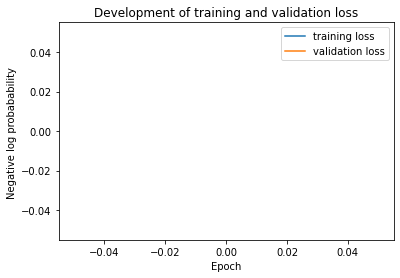

The mean squared error for this experiment is 1.0159607970714568
Creating new directory at experiments/results/10d_gp_sum_2020_06_29_15_56
Saving encoder
Saving decoder
Saving train_loss
Saving vali_loss
Saving task_mses
Saving config
Saving snapshot of the sytems


In [ ]:
run_experiment(config_file=sum_exp_config,
               experiment_name='1d_gp_sum',
              google_colab=google_colab)

##  Attention Model Experiment 

In [ ]:
aggregation_kwargs ={
      "aggregator": "BasicMLPAggregator",
      "insize": 128,
      "num_layers": 2,
      "num_neurons": 64,
      "dimout": 1
    }

In [ ]:
attention_exp_config = copy(base_config)
attention_exp_config['cnp_params']['aggregation_kwargs'] = aggregation_kwargs

  0%|          | 0/10 [00:00<?, ?it/s]

Training on GPU!
Decoder(
  (_process_input): Sequential(
    (0): Linear(in_features=138, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=2, bias=True)
  )
)
Encoder(
  (_process_input): Sequential(
    (0): Linear(in_features=11, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=128, bias=True)
  )
)
BasicMLPAggregator(
  (_process_input): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
  (softmax): Softmax(dim=1)
)


 10%|█         | 1/10 [00:00<00:01,  6.81it/s]

Mean training loss at epoch 0 :                         1.445
Mean Validation loss after 0 equals                     1.511



100%|██████████| 10/10 [00:01<00:00,  6.84it/s]


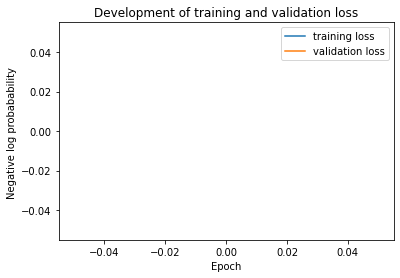

The mean squared error for this experiment is 1.0015557771921157
Creating new directory at experiments/results/10d_gp_attention_2020_06_29_15_56
Saving encoder
Saving decoder
Saving aggregator
Saving train_loss
Saving vali_loss
Saving task_mses
Saving config
Saving snapshot of the sytems


In [ ]:
run_experiment(config_file=attention_exp_config,
               experiment_name='1d_gp_attention',
              google_colab=google_colab)

##  Gated attention Model Experiment 

In [ ]:
aggregation_kwargs ={
      "aggregator": "GatedMLPAggregator",
      "insize": 128,
      "num_layers": 2,
      "num_neurons": 64,
      "dimout": 1
    }